## Starting my own model

In [1]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser

In [2]:
import multiprocessing

from gensim.models import Word2Vec

In [3]:
with open("df_clean_sub_date.csv", "rb") as fp:   # Unpickling
    df_clean = pickle.load(fp)

In [4]:
df_clean = df_clean[~df_clean.clean.str.contains("gt...")]

In [5]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [6]:
parameters = dict(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Google Model

In [3]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [88]:
google_model.most_similar(positive=["man"])

[('woman', 0.7664012312889099),
 ('boy', 0.6824870705604553),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903800010681),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119724273682),
 ('Robbery_suspect', 0.5584410429000854),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489762425422668)]

### DataFrame by Community

In [7]:
MR_subreddits = ['LadyMRAs', 'FeMRADebates', 'Masculism', 'MensRants', 'FeMRA', 'MRActivism',
                 'MensRightsLaw', 'MRRef']  # removed againstmansrights

Incel_subreddits = ['askanincel', 'BlackPillScience', 'IncelsWithoutHate', 'Braincels']

MGTOW_subreddits = ['MGTOW']

RedPill_subreddits = ['RedPillParenting', 'TRPOffTopic', 'GEOTRP', 'thankTRP', 'redpillbooks',
                      'becomeaman', 'RedPillWomen', 'TheBluePill', 'asktrp', 'TheRedPill']  # removed exredpill

In [ ]:
MR_df = df_clean.loc[df_clean['subreddit'].isin(MR_subreddits)]
Incel_df = df_clean.loc[df_clean['subreddit'].isin(Incel_subreddits)]
MGTOW_df = df_clean.loc[df_clean['subreddit'].isin(MGTOW_subreddits)]
RedPill_df = df_clean.loc[df_clean['subreddit'].isin(RedPill_subreddits)]

In [8]:
RedPill_df = df_clean.loc[df_clean['subreddit'].isin(RedPill_subreddits)]

## Community Models

In [9]:
reddits_df = [MR_df, Incel_df, MGTOW_df, RedPill_df]
reddits = ['MR', 'Incel', 'MGTOW', 'RedPill']

In [10]:
for i in range(4):
    sub_sent = [row.split() for row in reddits_df[i]['clean']]
    sub_phrases = Phrases(sub_sent, min_count=30)
    sub_bigram = Phraser(sub_phrases)
    sub_sentences = sub_bigram[sub_sent]

    Model = Word2Vec(**parameters)
    Model.build_vocab(sub_sentences)
    Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
    Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=30)

    Model.init_sims(replace=True)
    Model.wv.save(f"{reddits[i]}_wordvectors.kv")
    print(f"{reddits[i]}_wordvectors.kv saved")

MR_wordvectors.kv saved
Incel_wordvectors.kv saved
MGTOW_wordvectors.kv saved
RedPill_wordvectors.kv saved


## Time models

* Incels subrredits are not used, since they appear in 2017

In [9]:
def time_model_creation(model_df, community='reddit', years=[2014, 2015, 2016, 2017, 2018]):
    
    models = []
    
    sub = community
    
    for year in years:
        
        # Creating Sentences by time
        time_df = model_df.loc[model_df['year'] == year]
        time_sent = [row.split() for row in time_df['clean']]
        time_phrases = Phrases(time_sent, min_count=30)
        time_bigram = Phraser(time_phrases)
        time_sentences = time_bigram[time_sent]
        
        print(f'Year {year} sentences created')
        
        # Creating time Model
        Model = Word2Vec(**parameters)
        Model.build_vocab(time_sentences)
        Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
        Model.train(time_sentences, total_examples=Model.corpus_count, epochs=30)
        
        Model.init_sims(replace=True)
        Model.wv.save(f"{sub}_wordvectors_{year}.kv")
        
        models.append(Model)
        
        print(f"Created {sub}_wordvectors_{year}.kv")

In [10]:
years = [2014, 2015, 2016, 2017, 2018]

In [11]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['year'] = df_clean['Date'].dt.year
df_clean['year'] = df_clean['year'].mask(df_clean['year'] < 2015)
df_clean['year'] = df_clean['year'].fillna(2014)
df_clean = df_clean.astype({"year": int})

In [12]:
df_clean.drop(columns='Date', inplace=True)

In [13]:
MR_df = df_clean.loc[df_clean['subreddit'].isin(MR_subreddits)]
MGTOW_df = df_clean.loc[df_clean['subreddit'].isin(MGTOW_subreddits)]
RedPill_df = df_clean.loc[df_clean['subreddit'].isin(RedPill_subreddits)]

In [14]:
time_model_creation(RedPill_df, community="RP")

Year 2014 sentences created
Created RP_wordvectors_2014.kv
Year 2015 sentences created
Created RP_wordvectors_2015.kv
Year 2016 sentences created
Created RP_wordvectors_2016.kv
Year 2017 sentences created
Created RP_wordvectors_2017.kv
Year 2018 sentences created
Created RP_wordvectors_2018.kv


## Comparing community models

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [5]:
def make_graph(model, word):
    G = nx.Graph()
    G.add_node(word)
    
    for close_word in model.most_similar(positive=[word], topn=5):
        close_word=close_word[0]
        G.add_node(close_word)
        G.add_edge(word, close_word)
        G[word][close_word]['weight'] = model.similarity(word, close_word) * 1000
        
        for other_word in model.most_similar(positive=[close_word], topn=3):
            other_word = other_word[0]
            G.add_node(other_word)
            G.add_edge(close_word, other_word)
            G[close_word][other_word]['weight'] = model.similarity(close_word, other_word) * 1000
    return G

* Cos similarity multiplied by 1000 to improve Fruchterman-Reingold force-directed algorithm

In [6]:
def comparing_models(models, word, titles=['First 1%', 'Last 1%'],
                     seed=6, rows=2, cols=2, suptitle='Reddit Communities'):

    Gs = [make_graph(model, word) for model in models]

    nr_rows = rows
    nr_cols = cols
    
    fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*8,nr_rows*4), squeeze=False)
    plt.suptitle(suptitle, y=0.95, fontsize=15)

    for r in range(0,nr_rows):
        for c in range(0, nr_cols):  
            col = r*nr_cols+c
            if col < len(models):
                color = ['yellow']
                color.extend(['skyblue']*(len(Gs[col].nodes)-1))
                
                axs[r][c].set(title=titles[col])
                nx.draw(Gs[col], pos=nx.spring_layout(Gs[col], seed=seed), with_labels=True,
                        node_color = color, font_size=12, ax=axs[r][c])


In [7]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [8]:
def print_similar(models, word, model_names=["MR", "Incel", "MGTOW", "RedPill", "Google"], n=10, comparing="Reddit"):
    d = {}
    for i in range(len(models)):
        t = models[i].most_similar(positive=[word], topn=n)
        d[model_names[i]] = [t[j][0] for j in range(n)]
        
    df = pd.DataFrame(d)
    print(f'Words most similar to {word} on {comparing}')
    return df

In [9]:
def plot_cossim(word1, word2, models, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="Reddit"):
    x = communities
    y = [model.similarity(word1, word2) for model in models]
    fig, ax = plt.subplots()
    ax.set(title=(f'Cossim between {word1} and {word2} on {comparing}'))
    sns.barplot(x, y, ax=ax);

In [10]:
def google_cossim(word, models, google_model, communities=["MR", "Incel", "MGTOW", "RedPill"], comparing="reddit"):
    x = communities
    y = [cos_sim(model.__getitem__(word), google_model.__getitem__(word)) for model in models]
    fig, ax = plt.subplots()
    ax.set(title=(f'Cossim of {word} in google model and in {comparing} model'))
    sns.barplot(x, y, ax=ax);

In [12]:
from gensim.models import KeyedVectors

MGTOW_model = KeyedVectors.load("MGTOW_wordvectors.kv", mmap='r')
Incel_model = KeyedVectors.load("Incel_wordvectors.kv", mmap='r')
MR_model = KeyedVectors.load("MR_wordvectors.kv", mmap='r')
RP_model = KeyedVectors.load("RedPill_wordvectors.kv", mmap='r')

#### Table of most similar words 

In [13]:
word = 'rape'
n = 10
models = [MR_model, Incel_model, MGTOW_model, RP_model]
print_similar(models, word, n=n, comparing='Alt Righters Reddits')

Words most similar to rape on Alt Righters Reddits


,MR,Incel,MGTOW,RedPill
0,sexual_assault,murder,sexual_assault,sexual_assault
1,rapist,assault,rapist,rapist
2,assault,rape_murder,assault,assault
3,crime,violence,sexually_assault,sexually_assault
4,rape_victim,abuse,falsely_accuse,rape_victim
5,victim,sexual_assault,crime,falsely_accuse
6,perpetrator,rapist,accuse,murder
7,false_accusation,kidnapping,consensual_sex,accuse_rape
8,murder,molestation,abuse,false_accusation
9,sexually_assault,rape_victim,sexual_harassment,consensual_sex


#### Cos Similarity between two words in each community

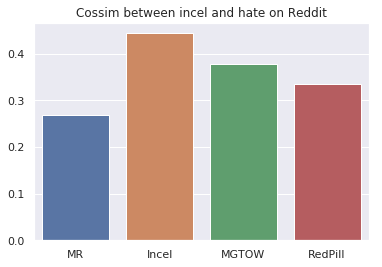

In [14]:
word1 = 'incel'
word2 = 'hate'
models = [MR_model, Incel_model, MGTOW_model, RP_model]
plot_cossim(word1, word2, models)

#### Cos Similarity between word in each community and in google (how much that word changes)

* Words used rarely change less than frequently used words

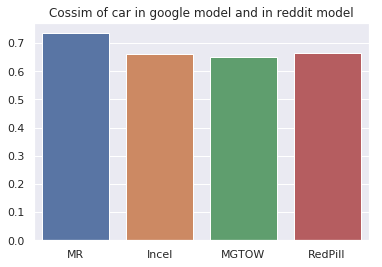

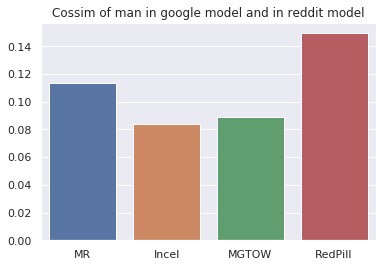

In [15]:
word1 = 'car'
word2 = 'man'
models = [MR_model, Incel_model, MGTOW_model, RP_model]
google_cossim(word1, models, google_model)
google_cossim(word2, models, google_model)

#### Graph of closest words for each community

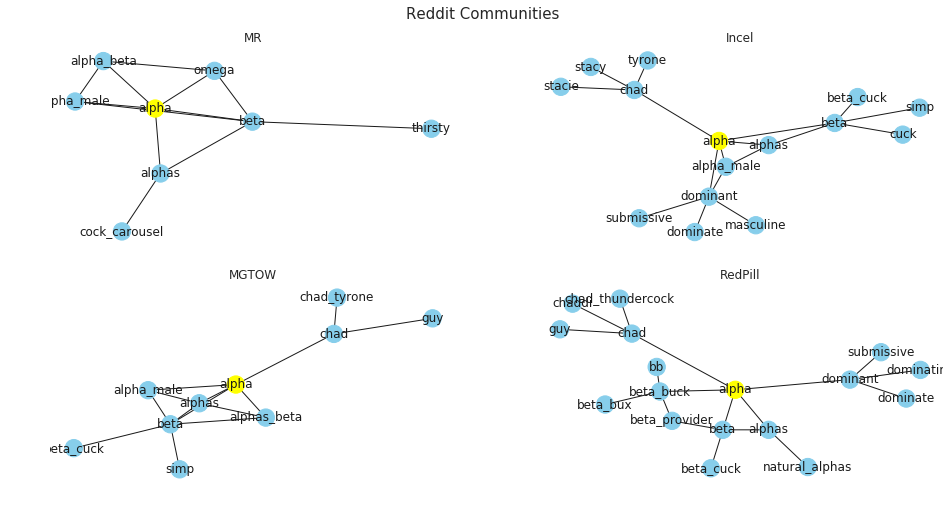

In [16]:
word = 'alpha'
comparing_models(models, word, titles=["MR", "Incel", "MGTOW", "RedPill"])

## Comparing time models

In [17]:
years = [2014, 2015, 2016, 2017, 2018]

In [18]:
years_str = list(map(str, years))
years_str[0]='2012-2014'

In [19]:
MGTOW_models = []
for year in years:
    MGTOW_models.append(KeyedVectors.load(f"MGTOW_wordvectors_{year}.kv", mmap='r'))

In [20]:
MR_models = []
for year in years:
    MR_models.append(KeyedVectors.load(f"MR_wordvectors_{year}.kv", mmap='r'))

In [21]:
RP_models = []
for year in years:
    RP_models.append(KeyedVectors.load(f"RP_wordvectors_{year}.kv", mmap='r'))

#### Tables of most similar words by time for each community

In [22]:
# MGTOW
word = 'woman'
n = 10
print_similar(MGTOW_models, word, n=n, model_names=years_str, comparing='MGTOW')

Words most similar to woman on MGTOW


,2012-2014,2015,2016,2017,2018
0,man,man,man,man,man
1,lady,want,want,simply,simply
2,victim,male,female,one,one
3,hypergamy,sex,simply,want,female
4,prostitute,female,reason,mean,want
5,girl,attractive,mean,female,male
6,person,relationship,way,male,partner
7,sex,desire,male,way,sex
8,female,way,people,think,attractive
9,sound_like,attract,one,reason,mean


In [23]:
# MR
word = 'woman'
n = 10
print_similar(MR_models, word, n=n, model_names=years_str, comparing="Man's Right")

Words most similar to woman on Man's Right


,2012-2014,2015,2016,2017,2018
0,man,man,man,man,man
1,male,male,male,male,people
2,female,female,female,female,girl
3,society,people,likely,likely,partner
4,people,likely,expect,girl,boy
5,girl,society,child,stem_field,male
6,way,boy,society,want,want
7,likely,girl,partner,boy,female
8,gender,mean,socialise,child,high_status
9,equally,sex,people,dangerous_job,likely


In [24]:
# Red Pill
word = 'woman'
n = 10
print_similar(RP_models, word, n=n, model_names=years_str, comparing="Red Pill")

Words most similar to woman on Red Pill


,2012-2014,2015,2016,2017,2018
0,man,man,man,man,man
1,attract,attract,attract,attract,attract
2,one,mean,mean,female,female
3,mean,attractive,female,attractive,attractive
4,attractive,male,male,mean,one
5,partner,one,one,one,mean
6,desirable,female,attractive,male,partner
7,male,simply,partner,partner,male
8,female,partner,simply,high_value,high_value
9,simply,obviously,sex,guy,desire


#### Cos Similarity of two words over time

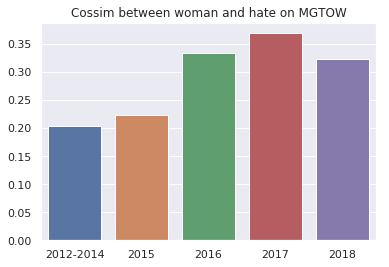

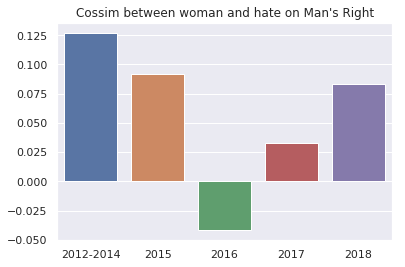

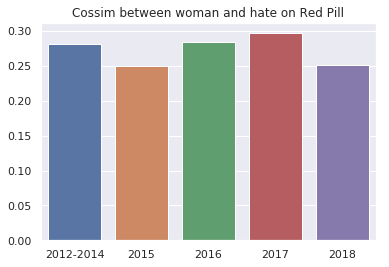

In [25]:
word1 = 'woman'
word2 = 'hate'
plot_cossim(word1, word2, MGTOW_models, communities=years_str, comparing="MGTOW")
plot_cossim(word1, word2, MR_models, communities=years_str, comparing="Man's Right")
plot_cossim(word1, word2, RP_models, communities=years_str, comparing="Red Pill")

#### Cos Similarity between a word in community model and google model by time (how much this word has changed over time)

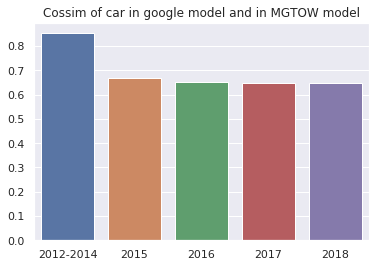

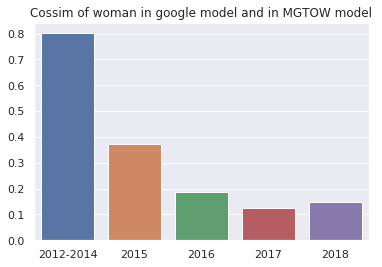

In [26]:
google_cossim('car', MGTOW_models, google_model, communities=years_str, comparing='MGTOW')
google_cossim('woman', MGTOW_models, google_model, communities=years_str, comparing='MGTOW')

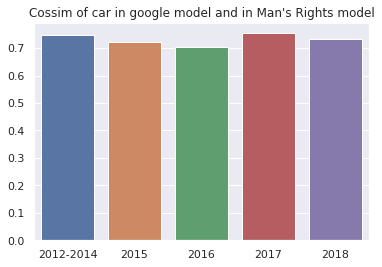

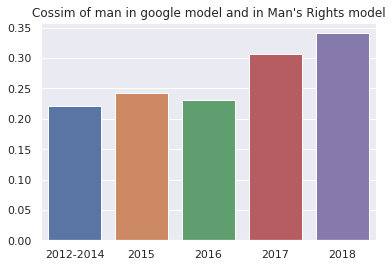

In [27]:
google_cossim('car', MR_models, google_model, communities=years_str, comparing="Man's Rights")
google_cossim('man', MR_models, google_model, communities=years_str, comparing="Man's Rights")

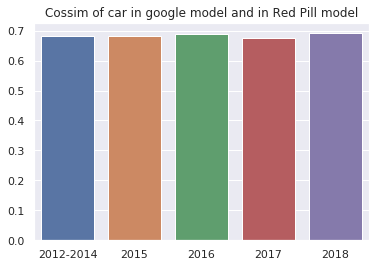

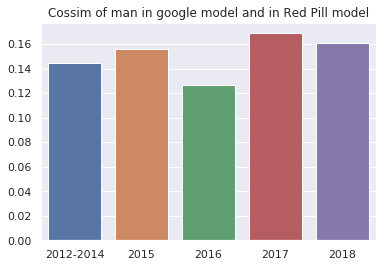

In [28]:
google_cossim('car', RP_models, google_model, communities=years_str, comparing="Red Pill")
google_cossim('man', RP_models, google_model, communities=years_str, comparing="Red Pill")

#### Graph of closest words over time

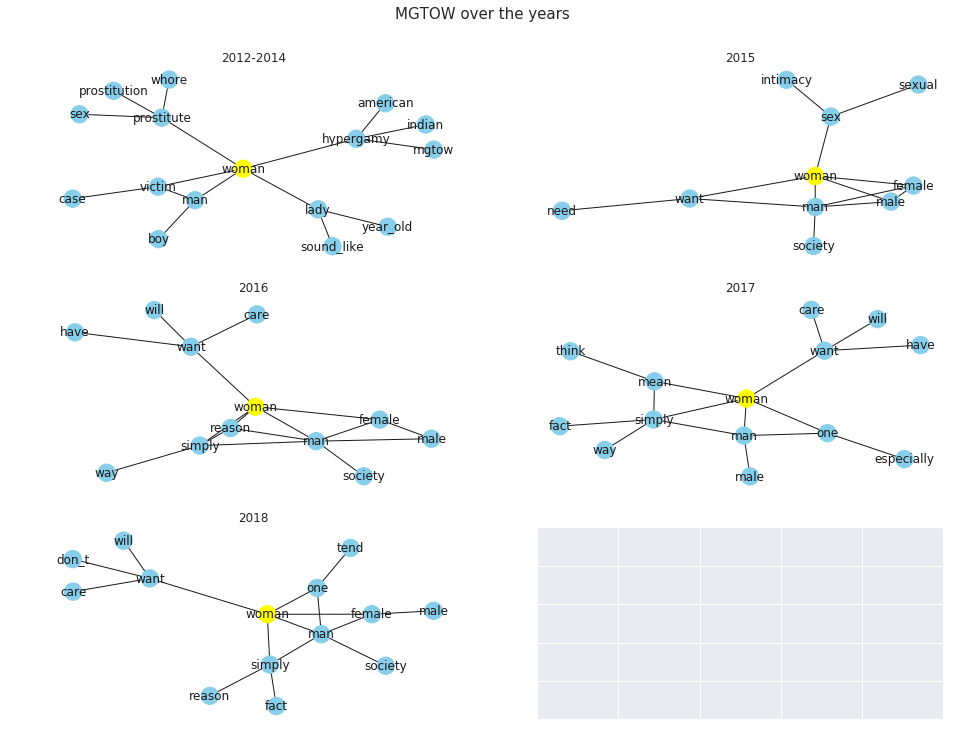

In [29]:
word = 'woman'
comparing_models(MGTOW_models, word, titles=years_str, rows=3, cols=2, suptitle='MGTOW over the years')

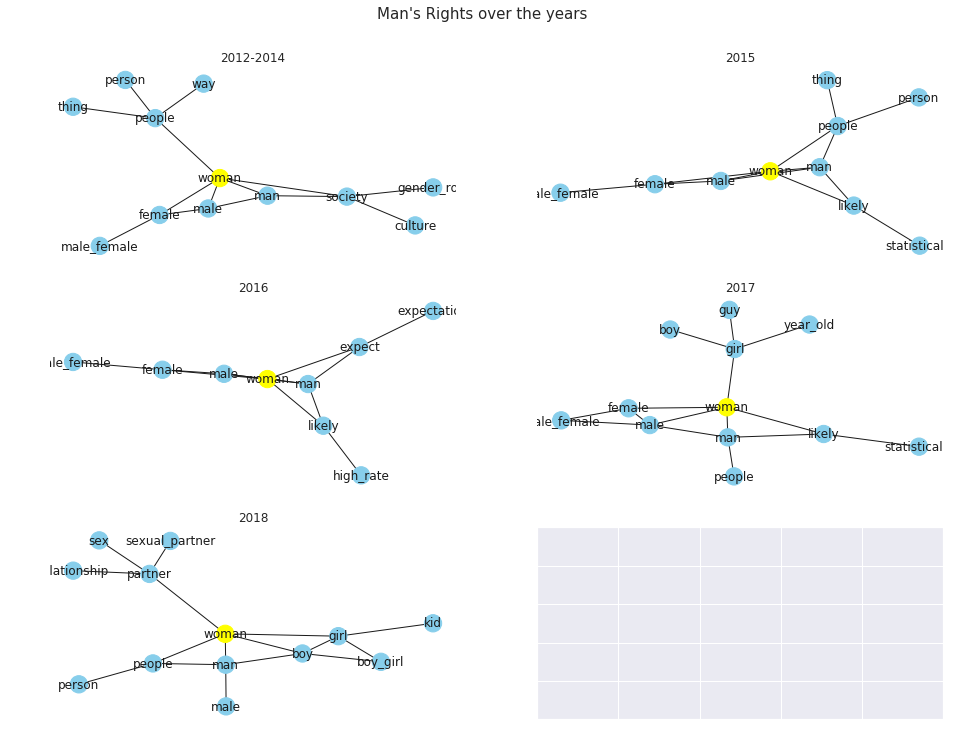

In [30]:
word = 'woman'
comparing_models(MR_models, word, titles=years_str, rows=3, cols=2, suptitle="Man's Rights over the years")

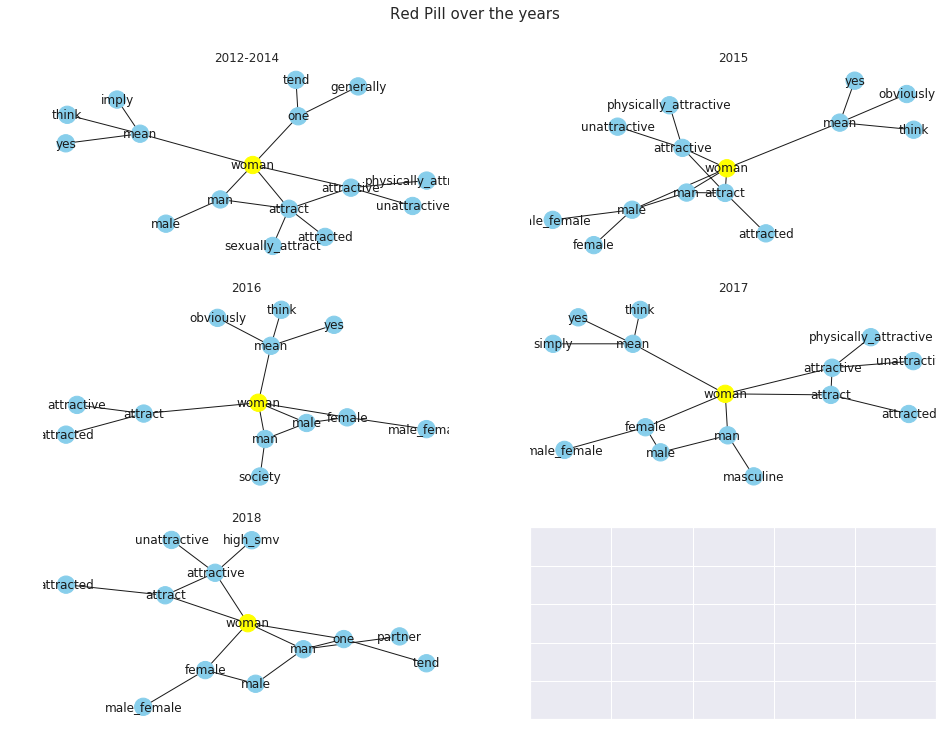

In [31]:
word = 'woman'
comparing_models(RP_models, word, titles=years_str, rows=3, cols=2, suptitle="Red Pill over the years")

##### T-SNE  Visualization algorithm (William L. Hamilton paper)

To visualize semantic change for a wordwiin twodimensions we employed the following procedure,which  relies  on  the  t-SNE  embedding  method(Van der Maaten and Hinton, 2008) as a subrou-tine:

* 1.  Find  the  union  of  the  wordwi’sknearestneighbors over all necessary time-points.
* 2.  Compute   the   t-SNE   embedding   of   thesewords on the most recent (i.e.,  the modern)time-point.
* 3.  For  each  of  the  previous  time-points,  holdall  embeddings  fixed,  except  for  the  targetword’s (i.e., the embedding forwi), and op-timize a new t-SNE embedding only for thetarget  word. We  found  that  initializing  theembedding for the target word to be the cen-troid  of  itsk′-nearest  neighbors  in  a  time-point was highly effective.

Thus, in this procedure the background words arealways shown in their “modern” positions, whichmakes sense given that these are the current mean-ings of these words. This approximation is neces-sary, since in reality all words are moving.

#### Aligning historical embeddings

We   use   orthogonal   Procrustes   to   align   thelearned  low-dimensional  embeddings.    DefiningW(t)∈Rd×|V|as the matrix of word embeddingslearned  at  yeart,  we  align  across  time-periodswhile preserving cosine similarities by optimizing:

$R(t)= arg   minQ>Q=I‖QW(t)−W(t+1)‖F $

The  solution  correspondsto  the  best  rotational  alignment  and  can  be  ob-tained  efficiently  using  an  application  of  SVD

##### Pair-wise  similarity  time-series

$ s(t)(wi,wj) =cos-sim(w(t)i,w(t)j) $

In [32]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline